In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib notebook

In [9]:
#training data for due dates from January 2018 to June 2019
df = pd.read_table('model_duedates_nig_3dormancy_201801_201906.txt', header = 0, sep = '\t')
df = df.loc[:, df.columns != 'customernumber']
#predicting risk of disconnection for due dates in Nov 2019
df_to_predict = pd.read_table('NIG_predict_20191125_30.txt', header = 0, sep = '\t')

print('-----LOADING DONE-----')

-----LOADING DONE-----


In [10]:
df_to_predict.fillna(df.mean(), inplace=True)
df_to_predict.drop('inactive_on_duedate', inplace=True, axis=1)
df.fillna(df.mean(), inplace=True)
#activate sample only if there is a need for GridSearch later on, otherwise train the data with full set.
#df = df.sample(30000)
y = df.iloc[:,-1]
X = df.iloc[:,:-1]
X_to_predict = df_to_predict.loc[:, df_to_predict.columns != 'customernumber']
print(X_to_predict.head())


   isDTH  days_customer_tenure  days_product_tenure  week_day  day_month  \
0      0                  2286                 1003         6         29   
1      0                  1807                  284         6         29   
2      0                  1425                  995         7         30   
3      0                   498                  465         7         30   
4      1                  4813                  486         7         30   

   month_year  active_days_last_3months  active_days_last_6months  \
0          11                        23                        84   
1          11                        84                       115   
2          11                        83                       149   
3          11                        52                        81   
4          11                        78                       162   

   cont_active_days_bfduedate  
0                          25  
1                          25  
2                          24  


In [11]:
#there is a need for balancing the classes, as dependent variable distribution is around 30% for positive cases - 70% for negative
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
print('----SPLIT READYY-------')

----SPLIT READYY-------


In [5]:
#GridSearch - looking for best combination of parameters for GradientBoostingClassifier - optimizing AUC
gbc = GradientBoostingClassifier(random_state=0)
grid_values_gbc = {'n_estimators':[150,200,300,400],'learning_rate':[0.01, 0.1, 0.2, 0.3, 0.4]}
grid_gbc_auc = GridSearchCV(gbc, param_grid = grid_values_gbc, cv = 3,  scoring='roc_auc')
grid_gbc_auc.fit(X_train, y_train, sample_weights)
print('Grid best parameter (max. roc_auc): ', grid_gbc_auc.best_params_)
print('Grid best score (roc_auc): ', grid_gbc_auc.best_score_)

('Grid best parameter (max. roc_auc): ', {'n_estimators': 200, 'learning_rate': 0.1})
('Grid best score (roc_auc): ', 0.8016701085178268)


In [11]:
#GridSearch - looking for best combination of parameters for RandomForestClassifier - optimizing AUC
rfc = RandomForestClassifier(random_state=0, n_jobs=-1, verbose=1)
grid_values_rfc = {'n_estimators':[200,400,600,1000],'max_features':['auto', 'sqrt', 'log2']}
grid_rfc_auc = GridSearchCV(rfc, param_grid = grid_values_rfc, cv = 3,  scoring='roc_auc')
grid_rfc_auc.fit(X_train, y_train, sample_weights)
print('Grid best parameter (max. roc_auc): ', grid_rfc_auc.best_params_)
print('Grid best score (roc_auc): ', grid_rfc_auc.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]

('Grid best parameter (max. roc_auc): ', {'max_features': 'auto', 'n_estimators': 1000})
('Grid best score (roc_auc): ', 0.7526324818207231)


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.3s finished


In [12]:
#GridSearch - looking for best combination of parameters for LogisticRegression - optimizing AUC
lr = LogisticRegression(random_state=0, n_jobs=-1, verbose=1)
grid_values_lr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
grid_lr_auc = GridSearchCV(lr, param_grid = grid_values_lr, cv = 3,  scoring='roc_auc')
grid_lr_auc.fit(X_train, y_train, sample_weights)
print('Grid best parameter (max. roc_auc): ', grid_lr_auc.best_params_)
print('Grid best score (roc_auc): ', grid_lr_auc.best_score_)

C:\Users\g.delaheracasado\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\g.delaheracasado\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]('Grid best parameter (max. roc_auc): ', {'penalty': 'l1', 'C': 0.1})
('Grid best score (roc_auc): ', 0.7331899102972277)


In [13]:
#FINAL TRAINING OF GRADIENT BOOSTING CLASSIFIER WITH OPTIMIZED PARAMETERS

clf = GradientBoostingClassifier(random_state=0, n_estimators=200, learning_rate = 0.1).fit(X_train, y_train,sample_weights)
y_predict = clf.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, y_predict))
print('Precision Score: ', precision_score(y_test,y_predict))
print('Recall Score: ', recall_score(y_test,y_predict))
print ('Confusion Matrix', confusion_matrix(y_test, y_predict))
feature_importances_clf = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances_clf)



Accuracy Score:  0.7093122921271823
Precision Score:  0.6345515737580584
Recall Score:  0.7653583373831508
Confusion Matrix [[92639 46257]
 [24624 80319]]
                            importance
active_days_last_6months      0.613336
active_days_last_3months      0.288279
cont_active_days_bfduedate    0.045774
month_year                    0.018575
days_product_tenure           0.011497
isDTH                         0.009669
day_month                     0.007034
week_day                      0.002917
days_customer_tenure          0.002917


   customernumber  isDTH  days_customer_tenure  days_product_tenure  week_day  \
0       310890024      0                  2286                 1003         6   
1       300085295      0                  1807                  284         6   
2       254380475      0                  1425                  995         7   
3        81222747      0                   498                  465         7   
4       257995888      1                  4813                  486         7   

   day_month  month_year  active_days_last_3months  active_days_last_6months  \
0         29          11                        23                        84   
1         29          11                        84                       115   
2         30          11                        83                       149   
3         30          11                        52                        81   
4         30          11                        78                       162   

   cont_active_days_bfduedate  l

C:\Users\g.delaheracasado\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


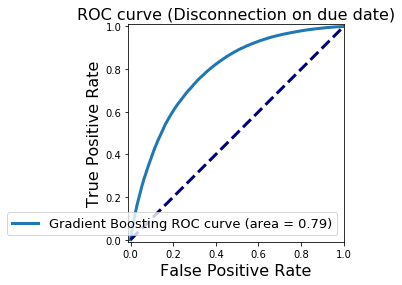

In [6]:
#Gradient Boosting - obtaining predictions and calculating ROC on testing data

#obtaining predictions for due dates in Nov 2019
y_to_predict_clf = clf.predict_proba(X_to_predict)[:,1]
df_to_predict['likelihood_disconnect'] = y_to_predict_clf
df_to_predict.to_csv(r'likelihood_20191125_30_nig.csv')
print(df_to_predict.head())

#calculating ROC curve on testing data
y_predict_clf = clf.predict_proba(X_test)[:,1]
fpr_lr_clf, tpr_lr_clf, _ = roc_curve(y_test, y_predict_clf)
roc_auc_lr_clf = auc(fpr_lr_clf, tpr_lr_clf)
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr_clf, tpr_lr_clf, lw=3, label='Gradient Boosting ROC curve (area = {:0.2f})'.format(roc_auc_lr_clf))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (Disconnection on due date)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [15]:
#FINAL TRAINING OF RANDOM FOREST CLASSIFIER WITH OPTIMIZED PARAMETER
rf = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators = 1000, verbose=1, max_features = 'auto').fit(X_train, y_train,sample_weights)
y_predict = rf.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, y_predict))
print('Precision Score: ', precision_score(y_test,y_predict))
print('Recall Score: ', recall_score(y_test,y_predict))
print('AUC Score: ', roc_auc_score(y_test, y_predict))

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   23.0s finished


Accuracy Score:  0.7091523505263719
Precision Score:  0.6697906997634518
Recall Score:  0.6394614219147537
AUC Score:  0.7006344086880529
                            importance
days_customer_tenure          0.213830
active_days_last_6months      0.198261
days_product_tenure           0.154954
active_days_last_3months      0.141745
day_month                     0.098903
cont_active_days_bfduedate    0.079020
week_day                      0.054537
month_year                    0.048114
isDTH                         0.010636


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   23.2s finished


<IPython.core.display.Javascript object>


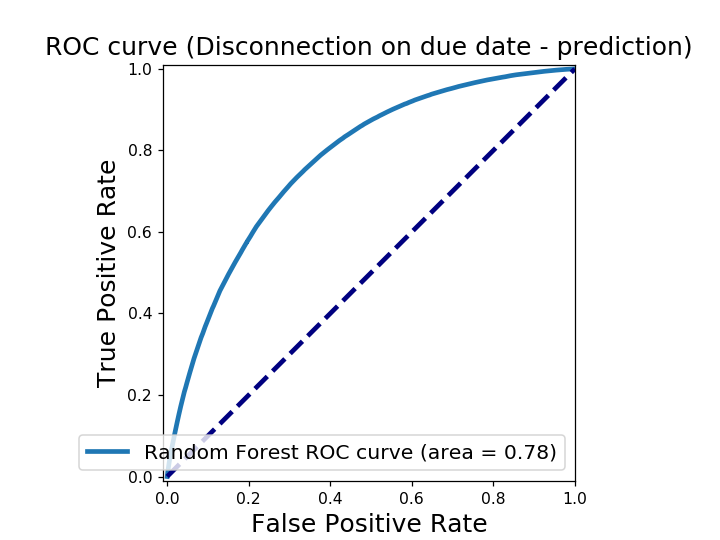

C:\Users\guill\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


In [16]:
#calculating ROC curve on testing data - Random Forest CLassifier
#######################
y_predict_rf = rf.predict_proba(X_test)[:,1]
fpr_lr_rf, tpr_lr_rf, _ = roc_curve(y_test, y_predict_rf)
roc_auc_lr_rf = auc(fpr_lr_rf, tpr_lr_rf)
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr_rf, tpr_lr_rf, lw=3, label='Random Forest ROC curve (area = {:0.2f})'.format(roc_auc_lr_rf))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (Disconnection on due date - prediction)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


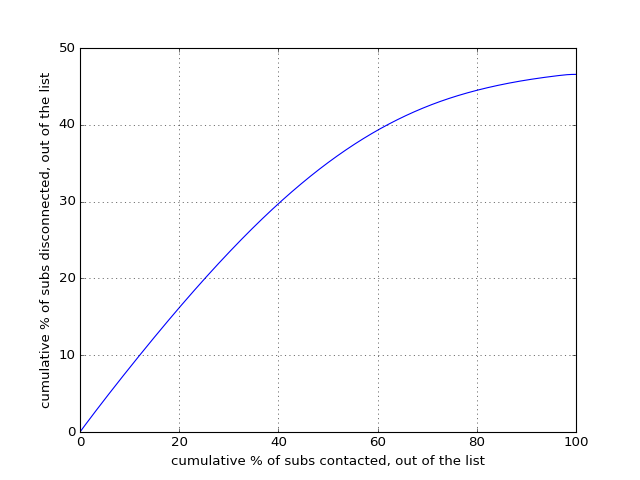

In [13]:
#calculating lift plot.

x = pd.DataFrame({'y': y_test, 'p': y_predict_clf, 'n': 1})
x = x.sort_values('p', ascending=False)
x['cumulative_percentage_y'] = 100*x.p.cumsum()/x.n.sum()
x['cumulative_percentage_n'] = 100*x.n.cumsum()/x.n.sum()
#x.to_csv(r'namedtt.csv')
#x.cumsum().plot('n', 'y', grid=True, legend = False)
x.plot('cumulative_percentage_n', 'cumulative_percentage_y', grid=True, legend = False)
plt.xlabel('cumulative % of subs contacted, out of the list')
plt.ylabel('cumulative % of subs disconnected, out of the list')